# Goal

Train model

Thanks to: OBELISK, FAIMED3D, MONAI
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

# Setup parameters

In [1]:
# MODEL
model_type = "CONDSEGUNET3D" #"OBELISKHYBRID" #"VNET" # "UNET3D" "OBELISKHYBRID"
loss_type  = "log_cosh_dice_loss" # DICE

# DATALOADER PARAMS
bs          = 2
nepochs     = 60
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
iso_sz    = 2
maxs      = [144, 144, 144]

# Train:Valid:Test = 60:20:20
valid_frac, test_frac = .20, .20

# Setup paths

In [2]:
import os

# Paths to (1) code (2) data
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"

# stored code
deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"

# stored data
model_src   = f"{data_src}/saved_models"
label_src   = f"{data_src}/PitMRdata/samir_labels"
ABIDE_src   = f"{data_src}/PitMRdata/ABIDE"

# stored runs Tensorboard
run_src     = f"{data_src}/runs"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: saved_landmarks, saved_models, sample_other_dsets, Labels, saved_dset_metadata, runs, saved_preds, PitMRdata
Folders in label src (data w labels): 50155-50212, 50313-50372, 50213-50312, 50373-50453, 50002-50153
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [3]:
# %load_ext autoreload
# %autoreload 2

In [4]:
# imports (# Piece)
from transforms import AddChannel, Iso, PadSz,\
                       ZScale, \
                       GNoise, GBlur,\
                       RandBright, RandContrast, \
                       RandDihedral, MattAff
        
        
from helpers.metrics import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet

# Utilities
import os, sys, gc, time, pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

# Data

In [5]:
# Get data dict
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())

In [6]:
print(len(items))

335


In [7]:
# remove bad label 50132
items = [item for item in items if not item[0].startswith(f"{label_src}/50002-50153/50132")]
print(len(items))

334


# Split train/valid/test split

In [8]:
# save test set indices
with open(f"{model_src}/split_train_valid_test.pkl", 'rb') as f:
    train_idxs, valid_idxs, test_idxs, train_items, valid_items, test_items = pickle.load(f)
    print("train, valid, test", len(train_items), len(valid_items), len(test_items))

train, valid, test 202 66 66


In [9]:
# length  = len(items)
# indices = np.arange(length)
# np.random.shuffle(indices)
# #rank0_first(lambda: np.random.shuffle(indices))

# test_split   = int(test_frac  * length)
# valid_split  = int(valid_frac * length) + test_split

# test_idxs    = indices[:test_split] 
# valid_idxs   = indices[test_split:valid_split]
# train_idxs   = indices[valid_split:]

# train_items = [items[i] for i in train_idxs]
# valid_items = [items[i] for i in valid_idxs]
# test_items  = [items[i] for i in test_idxs]

# # print
# print(f"Total  {len(items)} items in dataset.")
# print(f"Train: {len(train_items)} items.")
# print(f"Valid: {len(valid_items)} items.")
# print(f"Test:  {len(test_items)} items.")

In [10]:
# # save test set indices
# with open(f"{model_src}/split_train_valid_test.pkl", 'wb') as f:
#     pickle.dump([train_idxs, valid_idxs, test_idxs, train_items, valid_items, test_items], f)

# Transforms

In [11]:
class AddAtlas(ItemTransform):
    split_idx = None
    
    def __init__(self, items):
        self.n = len(items)
        self.items = items
    
    def encodes(self, item):
        atlas_item = self.items[np.random.randint(self.n)]
        return item, atlas_item
    
class IsoAtlas(ItemTransform):
    split_idx = None
    
    def __init__(self, new_sp = 2):
        self.new_sp = new_sp
        
    def encodes(self, x):
        input1, atlas1 = x
        return Iso(self.new_sp)(input1), Iso(self.new_sp)(atlas1)
    
class ZScaleAtlas(ItemTransform):
    split_idx = None
    
    """
    normalize a target image by subtracting the mean of foreground pixels
    and dividing by the standard deviation
    Source: https://github.com/jcreinhold/intensity-normalization/blob/master/intensity_normalization/normalize/zscore.py
    """
 
    # batch BCDHW
    def encodes(self, x):
        input1, atlas1 = x    
        return ZScale()(input1), ZScale()(atlas1)
    
class AddChAtlas(ItemTransform):
    split_idx = None
    
    def encodes(self, x):
        input1, atlas1 = x
        return AddChannel()(input1), AddChannel()(atlas1)
    
class MattAffAtlas(ItemTransform):
    split_idx = 0
    
    def __init__(self, p=0.5, strength=0.05):
        self.p        = p
        self.strength = strength
    
    def encodes(self, x):
        input1, atlas1 = x
        return MattAff(p=self.p, strength=self.strength)(input1), atlas1

class ConcatChannel(ItemTransform):
    split_idx = None
    
    def encodes(self, x):
        input1, atlas1 = x
        mr,mk = input1
        atlas_mr, atlas_mk = atlas1
        return torch.cat([mr, atlas_mr, atlas_mk], dim=1), mk

In [12]:
p = 0.5

item_tfms  = [AddAtlas(items), IsoAtlas(iso_sz), PadSz(maxs)]
batch_tfms = [ZScaleAtlas(), AddChAtlas(), MattAffAtlas(p=p, strength=0.05), ConcatChannel()]

# batch_tfms = [
#     # normalize mean/std of foreground pixels
#     ZScale(),
#     # flip
#     RandDihedral(p=p),
#     # noise
#     GNoise(p=p, std_range=[0.01, 0.1]),
#     #GBlur(p=p,  kernel_size_range=[5, 11], sigma=0.5),
#     AddChannel(),
#     # affine
#     MattAff(p=p, strength=0.05)
# ]

# Dataloaders

In [13]:
 # tls, dls, cuda
tls = TfmdLists(items, item_tfms, splits=(train_idxs, valid_idxs))
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)
dls = dls.cuda()

In [15]:
b1 = dls.train.one_batch()
b2 = dls.valid.one_batch()

print(f"Train: Batch: len {len(b1)}, x: ", b1[0].shape, "y: ", b1[1].shape)
print(f"Valid: Batch: len {len(b2)}, x: ", b2[0].shape, "y: ", b2[1].shape)

Train: Batch: len 2, x:  torch.Size([2, 3, 144, 144, 144]) y:  torch.Size([2, 1, 144, 144, 144])
Valid: Batch: len 2, x:  torch.Size([2, 3, 144, 144, 144]) y:  torch.Size([2, 1, 144, 144, 144])


# Viz

In [34]:
# p = 1.0

# # tfms - make sure Affine happens in training
# item_tfms  = [AddAtlas(items), IsoAtlas(iso_sz), PadSz(maxs)]
# batch_tfms = [ZScaleAtlas(), AddChAtlas(), MattAffAtlas(p=p, strength=0.05), ConcatChannel()]

#  # tls, dls, cuda
# tls = TfmdLists(items, item_tfms, splits=(train_idxs, valid_idxs))
# dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)
# dls = dls.cuda()

# b1 = dls.train.one_batch()
# b2 = dls.valid.one_batch()

# print(f"Train: Batch: len {len(b1)}, x: ", b1[0].shape, "y: ", b1[1].shape)
# print(f"Valid: Batch: len {len(b2)}, x: ", b2[0].shape, "y: ", b2[1].shape)

Train: Batch: len 2, x:  torch.Size([2, 3, 144, 144, 144]) y:  torch.Size([2, 1, 144, 144, 144])
Valid: Batch: len 2, x:  torch.Size([2, 3, 144, 144, 144]) y:  torch.Size([2, 1, 144, 144, 144])


In [37]:
def viz_batch_item(b, idx):
    xb,yb = b
    x,y = xb[idx], yb[idx]
    # unsqueeze channel dim
    mr, atlas_mr, atlas_mk = x.cpu()
    mk                     = y.cpu().squeeze()
    
    input1 = mr, mk
    input2 = atlas_mr, atlas_mk
    
    viz_compare_inputs(input1, input2)

1: 
Bbox coords: (65, 66, 60) to (81, 79, 70). Size: 16, 13, 10.
Bounding box coord: from location (66, 60) of slice 65 to location (79, 70) of slice 81.
2: 
Bbox coords: (70, 74, 59) to (83, 85, 68). Size: 13, 11, 9.
Bounding box coord: from location (74, 59) of slice 70 to location (85, 68) of slice 83.


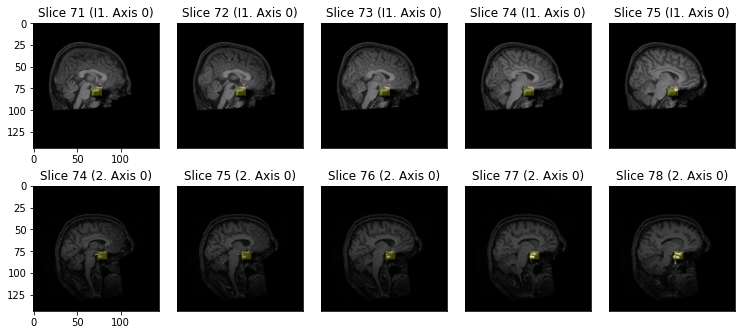

In [38]:
viz_batch_item(b1,1)

1: 
Bbox coords: (67, 69, 55) to (85, 85, 68). Size: 18, 16, 13.
Bounding box coord: from location (69, 55) of slice 67 to location (85, 68) of slice 85.
2: 
Bbox coords: (63, 68, 67) to (84, 82, 76). Size: 21, 14, 9.
Bounding box coord: from location (68, 67) of slice 63 to location (82, 76) of slice 84.


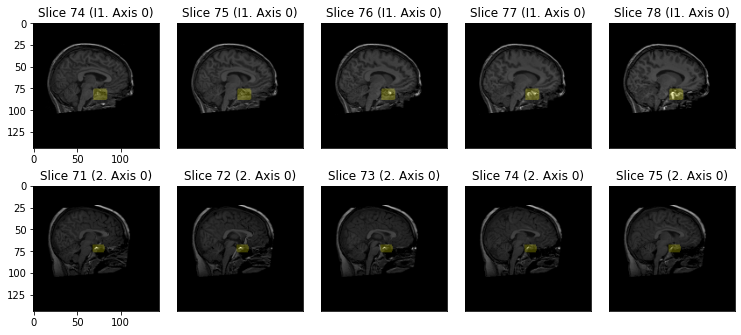

In [39]:
viz_batch_item(b2,1)

In [118]:
# test get one batch
# time_one_batch(dls)a

# Model

In [ ]:
if model_type == "VNET":
    # https://docs.monai.io/en/latest/networks.html#vnet
    device = torch.device("cuda:0")
    model = VNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
    ).to(device)
    
elif model_type == "CONDSEG_UNET3D":
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=3,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

elif model_type == "OBELISKHYBRID":
    full_res = maxs
    model    = obeliskhybrid_visceral(num_labels=2, full_res=full_res)
    
else:
    pass

# Loss

In [120]:
if loss_type == "log_cosh_dice_loss":
    loss_function = log_cosh_dice_loss
elif loss_type == "DICE":
    loss_function = dice_loss
else:
    loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

In [121]:
# # check
# print("Check")
# b = dls.one_batch()
# xb,yb = b
# print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
# predb = model(xb)
# print(f"Pred batch: {predb.shape}")
# loss = loss_function(predb, yb)
# print(f"Loss: {loss}")

Batch: 2. xb: torch.Size([2, 3, 144, 144, 144]), yb: torch.Size([2, 1, 144, 144, 144])
Pred batch: torch.Size([2, 2, 144, 144, 144])
Loss: 0.43252530694007874


# Model name

In [122]:
# Save test idxs + model + runs

# file name
model_time = rank0_first(lambda:get_time_id()) # 'Mon Oct 18 13:35:29 2010'
model_name = f"{model_type}_{loss_type}_iso_{iso_sz}mm_pad_{maxs[0]}_{maxs[1]}_{maxs[2]}_bs_{bs}_test_sz_{len(test_items)}_epochs_{nepochs}_time_{model_time}"
print(f"Model name: {model_name}")

Model name: UNET3D_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626279339_Wed_Jul_07_2021_hr_12_min_15


In [123]:
# save test set indices
with open(f"{model_src}/{model_name}_test_items.pkl", 'wb') as f:
    rank0_first(lambda:pickle.dump(list(test_items), f))

# Learner

In [124]:
# clear cache
gc.collect()
torch.cuda.empty_cache()
print_hardware_stats()

#GPU = 2, #CPU = 40
GPU Tesla V100-SXM2-16GB RAM Free: 11760MB | Used: 4400MB | Util  27% | Total 16160MB
GPU Tesla V100-SXM2-16GB RAM Free: 16157MB | Used: 3MB | Util   0% | Total 16160MB


In [125]:
learn = rank0_first(lambda:
            Learner(dls       = dls, \
                model     = model, \
                loss_func = log_cosh_dice_loss, \
                metrics   = dice_score, \
                model_dir = model_src, \
                cbs = [SaveModelCallback(monitor='dice_score', fname=model_name, with_opt=True)])
        )

# cbs TensorBoardCallback(Path(run_src)/model_name, trace_model=True)
# GPU
learn.model = rank0_first(lambda:learn.model.cuda())

# LR Finder

In [126]:
# print("PRE learn.fit one cycle")
# with learn.distrib_ctx():
#     learn.fit_one_cycle(2, 3e-3, wd = 1e-4)

In [127]:
# learn.lr_find()

In [128]:
print("PRE learn.fit one cycle")
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time
0,0.431082,0.430744,0.007440,01:35
1,0.430157,0.429581,0.012968,01:21
2,0.427583,0.424792,0.063651,01:22
3,0.411277,0.389815,0.199320,01:20
4,0.259439,0.157378,0.539716,01:21


Better model found at epoch 0 with dice_score value: 0.0074398755095899105.
Better model found at epoch 1 with dice_score value: 0.01296759583055973.
Better model found at epoch 2 with dice_score value: 0.06365084648132324.
Better model found at epoch 3 with dice_score value: 0.199320450425148.
Better model found at epoch 4 with dice_score value: 0.5397160649299622.


KeyboardInterrupt: 

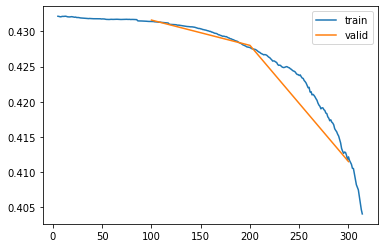

In [40]:
# learn.recorder.plot_loss()

In [3]:
# make dir
fig_src = f"{run_src}/{model_name}/figs"
Path(fig_src).mkdir(parents=True, exist_ok=True)

In [48]:
def save_plot_loss(self, skip_start=5, with_valid=True):
        plt.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
        if with_valid:
            idx = (np.array(self.iters)<skip_start).sum()
            plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(1), label='valid')
            plt.legend()
        plt.savefig(f'{fig_src}/loss.png', bbox_inches='tight')
        plt.close()

In [49]:
# save_plot_loss(learn.recorder)

In [56]:
@delegates(subplots)
def save_plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    #plt.show()
    plt.savefig(f'{fig_src}/metrics.png', bbox_inches='tight')
    plt.close()

In [57]:
save_plot_metrics(learn.recorder)

# Old

In [ ]:
# batch_tfms = [
#     # normalize mean/std of foreground pixels
#     ZScale(),
#     # affine + flips
#     RandomAffine(p=0.5, degrees=35, translate=0.1, scale=0.1),
#     RandDihedral(p=0.5),
#     # lighting
#     RandBright(p=0.5),
#     RandContrast(p=0.5),
#     # noise for generalizability
#     GNoise(p=0.5),
#     GBlur(p=0.5),
#     # add channel dim
#     AddChannel()

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

# ]

# Test

In [ ]:
# print("Test")
# xb, yb = dls.one_batch()
# xb, yb = xb.cpu(), yb.cpu()

# pb = model.cpu()(xb)
# print(xb.shape, pb.shape)
# print(f"logcosh dice loss {log_cosh_dice_loss(pb,yb)}")

In [ ]:
# # test:

# #dls.device = "cpu"

# start = time.time()

# x,y = dls.one_batch()
# #x,y = to_cpu(x), to_cpu(y)

# pred = learn.model(x)
# loss = learn.loss_func(pred, y)

# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s")
# print("Batch: x,y")
# print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

# print("Pred shape")
# print(type(pred), pred.shape, pred.dtype)

# print("Loss")
# print(loss)
# print(learn.loss_func)